In [1]:
# Install required packages (run this cell first)
!pip install numpy pandas matplotlib seaborn tensorflow scikit-learn plotly


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


In [2]:
# Create synthetic data with realistic patterns
def generate_energy_data(days=365):
    """Generate synthetic electricity consumption and carbon emission data"""
    dates = pd.date_range(start='2023-01-01', periods=days, freq='D')
    
    # Base patterns
    time_index = np.arange(len(dates))
    
    # Electricity consumption (in MWh) - has daily and weekly seasonality
    daily_seasonality = 0.8 * np.sin(2 * np.pi * time_index / 7)  # Weekly pattern
    yearly_seasonality = 0.5 * np.sin(2 * np.pi * time_index / 365)  # Yearly pattern
    trend = 0.001 * time_index  # Small upward trend
    
    # Weekday/weekend effect (weekends have lower consumption)
    weekday_effect = np.array([0.5 if date.weekday() >= 5 else 0 for date in dates])
    
    # Combine all effects for electricity
    electricity = (100 + daily_seasonality * 20 + 
                  yearly_seasonality * 30 + trend + 
                  weekday_effect * -15 + 
                  np.random.normal(0, 5, len(dates)))
    
    # Carbon emissions (in tons) - correlated with electricity but with different patterns
    # Higher emissions during winter (heating) and morning hours
    winter_effect = 0.3 * np.sin(2 * np.pi * (time_index + 100) / 365)  # Winter peak
    carbon = (0.5 * electricity +  # Base correlation with electricity
              winter_effect * 10 + 
              np.random.normal(0, 3, len(dates)))
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'electricity_consumption': electricity,
        'carbon_emission': carbon
    })
    
    return df

# Generate data
energy_df = generate_energy_data(365)
energy_df.set_index('date', inplace=True)

# Display first few rows
print("Synthetic Energy Data:")
print(energy_df.head())
print(f"\nDataset shape: {energy_df.shape}")

Synthetic Energy Data:
            electricity_consumption  carbon_emission
date                                                
2023-01-01                94.983571        49.254157
2023-01-02               112.077183        59.668713
2023-01-03               119.355613        62.664364
2023-01-04               115.334584        60.899161
2023-01-05                92.923130        47.070567

Dataset shape: (365, 2)


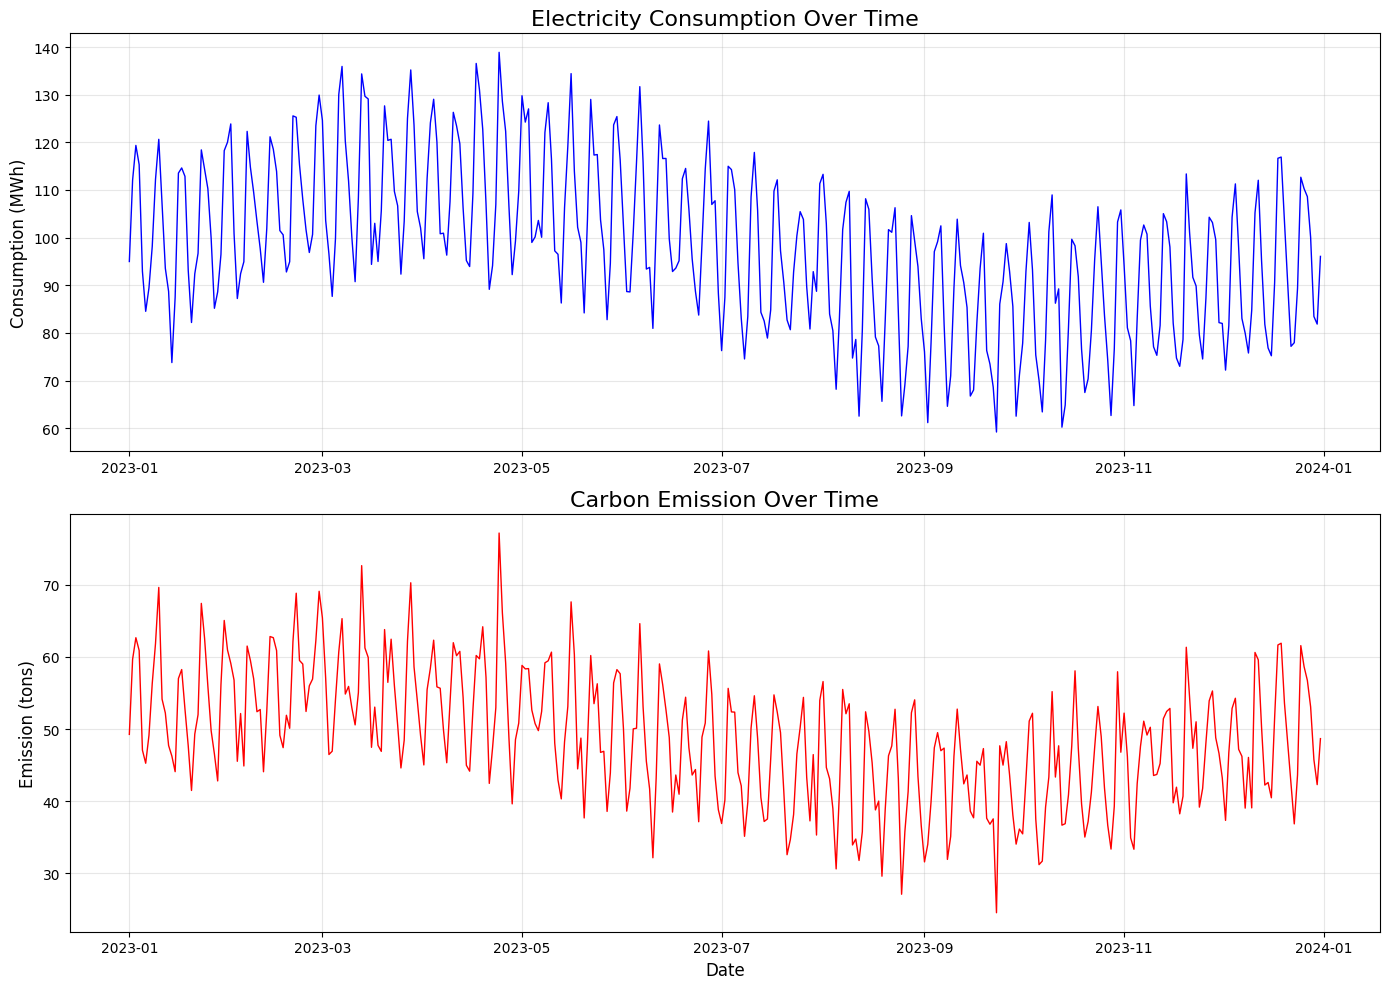

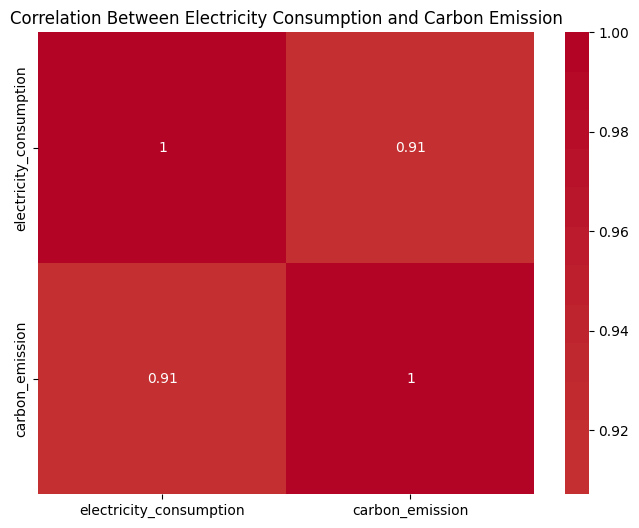

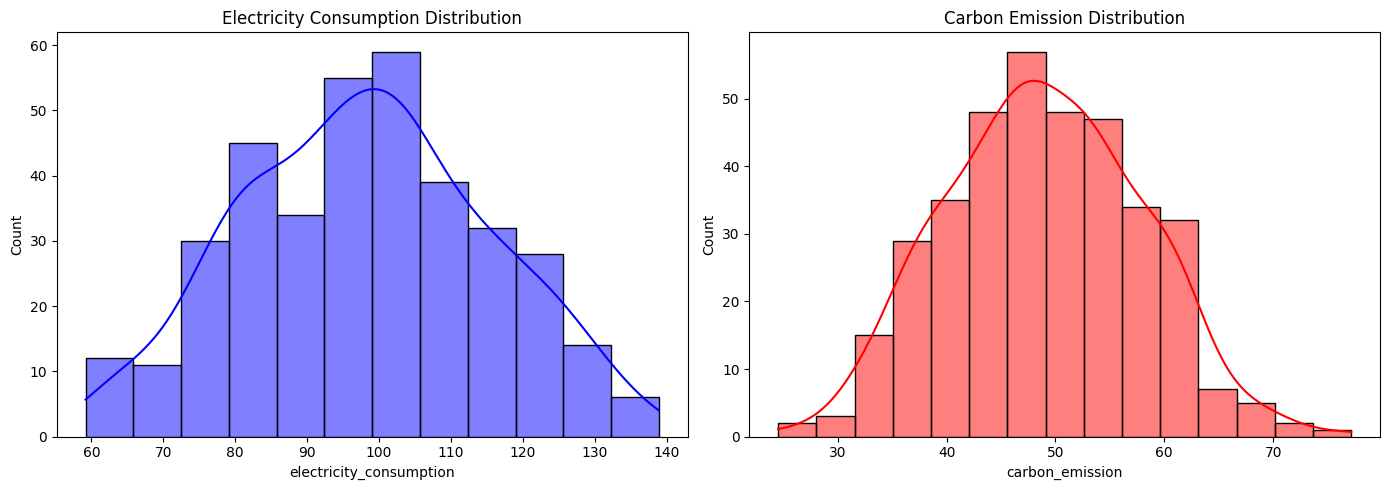

In [3]:
# Plot the generated data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Electricity consumption
ax1.plot(energy_df.index, energy_df['electricity_consumption'], 
         color='blue', linewidth=1)
ax1.set_title('Electricity Consumption Over Time', fontsize=16)
ax1.set_ylabel('Consumption (MWh)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Carbon emissions
ax2.plot(energy_df.index, energy_df['carbon_emission'], 
         color='red', linewidth=1)
ax2.set_title('Carbon Emission Over Time', fontsize=16)
ax2.set_ylabel('Emission (tons)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
correlation = energy_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Electricity Consumption and Carbon Emission')
plt.show()

# Distribution plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(energy_df['electricity_consumption'], kde=True, ax=ax1, color='blue')
ax1.set_title('Electricity Consumption Distribution')

sns.histplot(energy_df['carbon_emission'], kde=True, ax=ax2, color='red')
ax2.set_title('Carbon Emission Distribution')

plt.tight_layout()
plt.show()

In [4]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(energy_df)

# Create sequences for LSTM model
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])  # Past 'seq_length' days as features
        y.append(data[i])  # Next day as target
    return np.array(X), np.array(y)

# Set sequence length (using 30 days to predict next day)
SEQ_LENGTH = 30
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (268, 30, 2)
Testing data shape: (67, 30, 2)


In [5]:
# Build LSTM model
def create_lstm_model(seq_length, n_features):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(100, return_sequences=True, 
                   input_shape=(seq_length, n_features)))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Third LSTM layer
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    
    # Output layer (predicting both electricity and carbon)
    model.add(Dense(n_features))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create model
n_features = scaled_data.shape[1]
model = create_lstm_model(SEQ_LENGTH, n_features)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 100)             │          41,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,902 (593.37 KB)

 Trainable params: 151,902 (593.37 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, 
                               restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                              patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step - loss: 0.1093 - mae: 0.2631 - val_loss: 0.0261 - val_mae: 0.1371 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0384 - mae: 0.1572 - val_loss: 0.0260 - val_mae: 0.1385 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0362 - mae: 0.1545 - val_loss: 0.0272 - val_mae: 0.1401 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0335 - mae: 0.1511 - val_loss: 0.0248 - val_mae: 0.1369 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0306 - mae: 0.1439 - val_loss: 0.0256 - val_mae: 0.1362 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0318 - mae: 0.1487 - val_loss: 0.0236 - val_mae: 0.1328 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0313 - mae: 0.1474 - val_loss: 0.0247 - val_mae: 0.1351 - learning_rate: 0.0010
Epoch 8/100


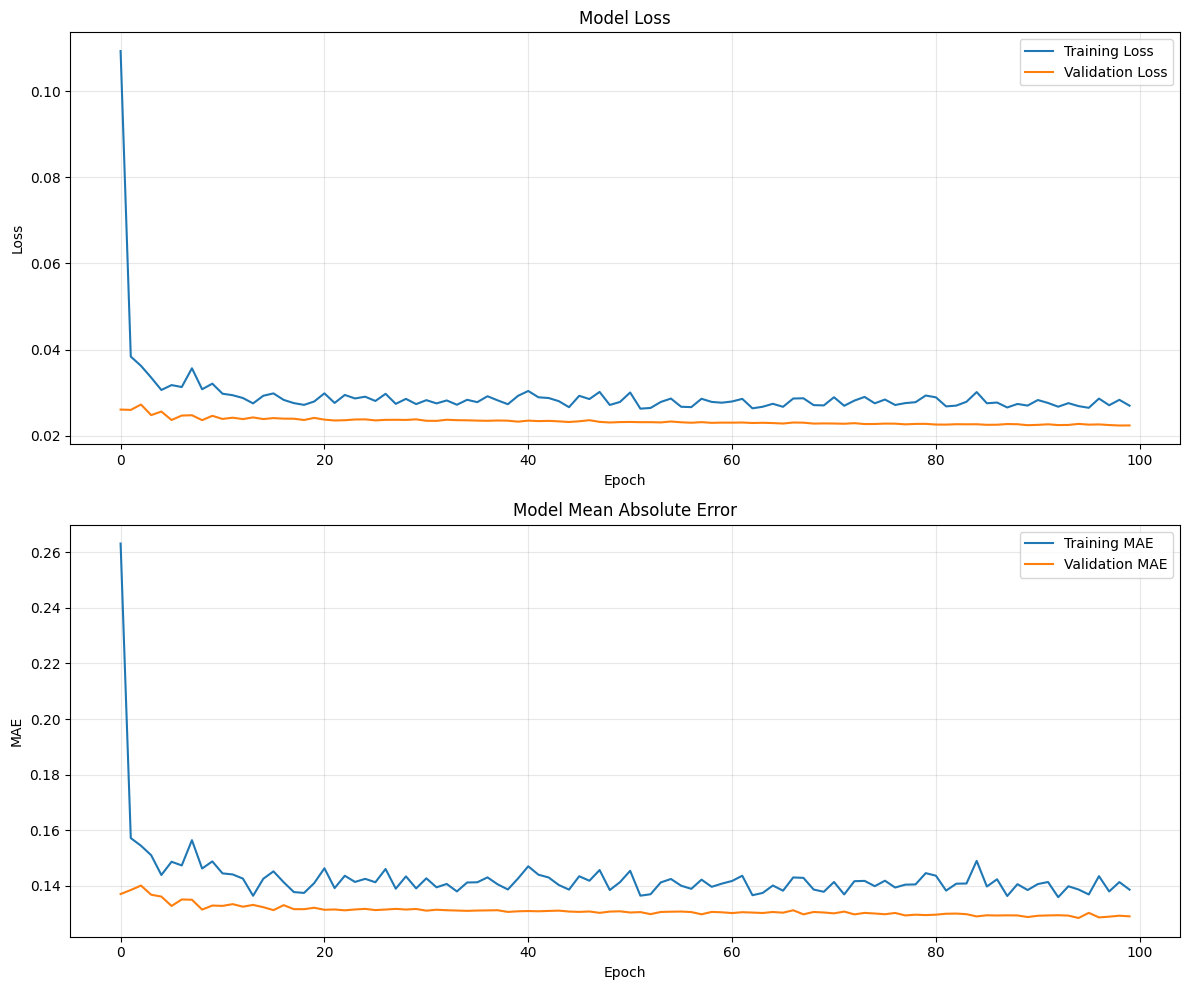

Test Loss: 0.0224
Test MAE: 0.1293


In [7]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot MAE
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title('Model Mean Absolute Error')
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

In [8]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)

# Create DataFrame for results
results_df = pd.DataFrame({
    'true_electricity': y_test_actual[:, 0],
    'pred_electricity': y_pred_actual[:, 0],
    'true_carbon': y_test_actual[:, 1],
    'pred_carbon': y_pred_actual[:, 1]
})

# Calculate metrics for electricity
elec_mae = mean_absolute_error(results_df['true_electricity'], results_df['pred_electricity'])
elec_rmse = np.sqrt(mean_squared_error(results_df['true_electricity'], results_df['pred_electricity']))

# Calculate metrics for carbon
carbon_mae = mean_absolute_error(results_df['true_carbon'], results_df['pred_carbon'])
carbon_rmse = np.sqrt(mean_squared_error(results_df['true_carbon'], results_df['pred_carbon']))

print("Electricity Consumption Forecast Metrics:")
print(f"MAE: {elec_mae:.2f} MWh")
print(f"RMSE: {elec_rmse:.2f} MWh\n")

print("Carbon Emission Forecast Metrics:")
print(f"MAE: {carbon_mae:.2f} tons")
print(f"RMSE: {carbon_rmse:.2f} tons")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step
Electricity Consumption Forecast Metrics:
MAE: 11.56 MWh
RMSE: 13.02 MWh

Carbon Emission Forecast Metrics:
MAE: 5.99 tons
RMSE: 7.07 tons


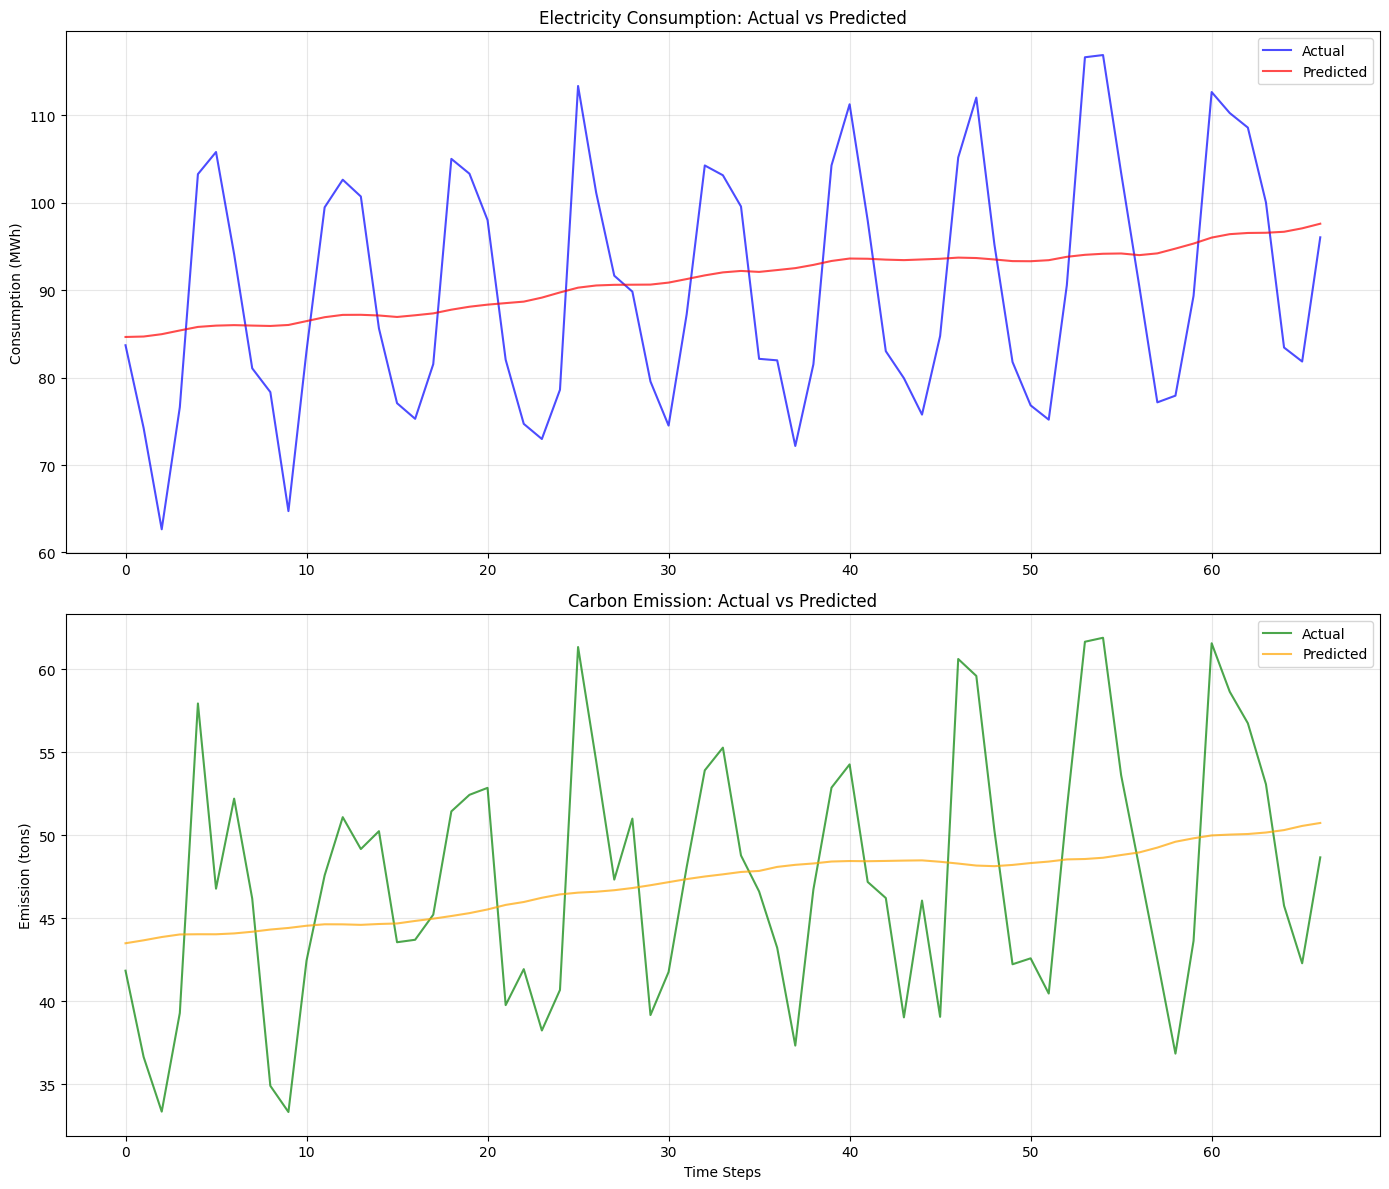

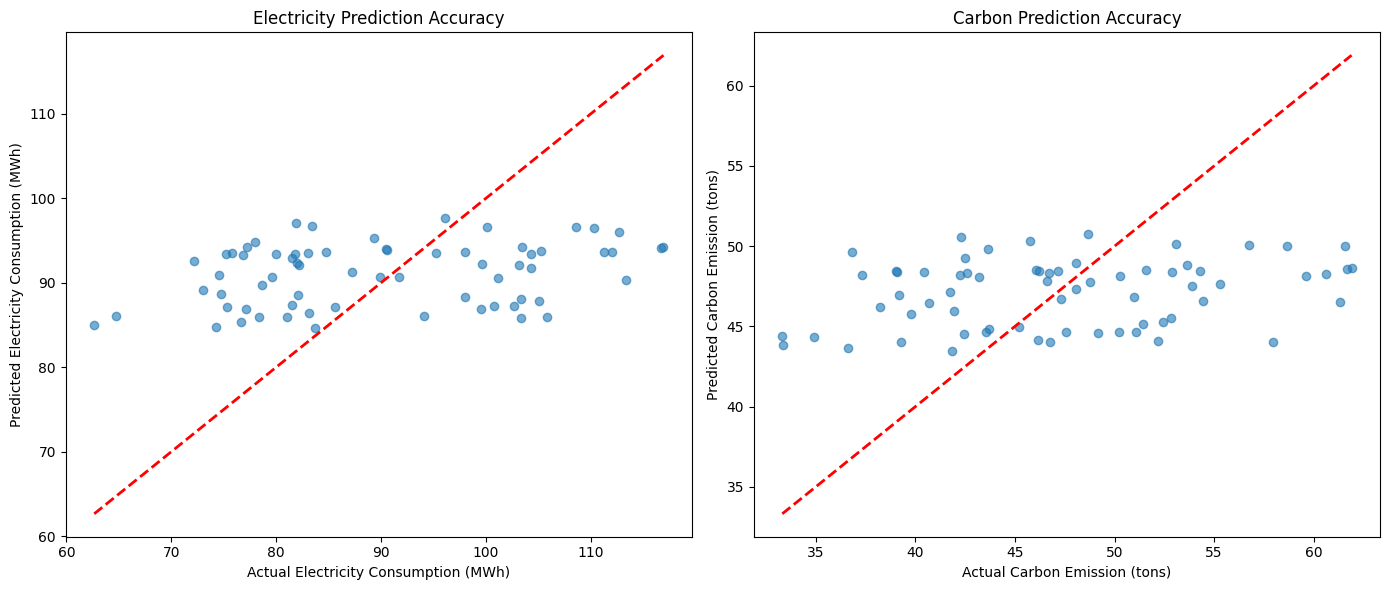

In [9]:
# Plot predictions vs actual
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Electricity consumption
ax1.plot(results_df['true_electricity'], label='Actual', color='blue', alpha=0.7)
ax1.plot(results_df['pred_electricity'], label='Predicted', color='red', alpha=0.7)
ax1.set_title('Electricity Consumption: Actual vs Predicted')
ax1.set_ylabel('Consumption (MWh)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Carbon emission
ax2.plot(results_df['true_carbon'], label='Actual', color='green', alpha=0.7)
ax2.plot(results_df['pred_carbon'], label='Predicted', color='orange', alpha=0.7)
ax2.set_title('Carbon Emission: Actual vs Predicted')
ax2.set_ylabel('Emission (tons)')
ax2.set_xlabel('Time Steps')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Electricity scatter plot
ax1.scatter(results_df['true_electricity'], results_df['pred_electricity'], alpha=0.6)
ax1.plot([results_df['true_electricity'].min(), results_df['true_electricity'].max()],
         [results_df['true_electricity'].min(), results_df['true_electricity'].max()], 
         'r--', lw=2)
ax1.set_xlabel('Actual Electricity Consumption (MWh)')
ax1.set_ylabel('Predicted Electricity Consumption (MWh)')
ax1.set_title('Electricity Prediction Accuracy')

# Carbon scatter plot
ax2.scatter(results_df['true_carbon'], results_df['pred_carbon'], alpha=0.6)
ax2.plot([results_df['true_carbon'].min(), results_df['true_carbon'].max()],
         [results_df['true_carbon'].min(), results_df['true_carbon'].max()], 
         'r--', lw=2)
ax2.set_xlabel('Actual Carbon Emission (tons)')
ax2.set_ylabel('Predicted Carbon Emission (tons)')
ax2.set_title('Carbon Prediction Accuracy')

plt.tight_layout()
plt.show()

In [10]:
def forecast_future(model, last_sequence, days_to_forecast, scaler, feature_names):
    """Forecast future values using the trained model"""
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days_to_forecast):
        # Get the prediction for the next day
        next_pred = model.predict(current_sequence.reshape(1, SEQ_LENGTH, n_features), verbose=0)
        future_predictions.append(next_pred[0])
        
        # Update the sequence: remove first day, add prediction
        current_sequence = np.vstack([current_sequence[1:], next_pred])
    
    # Inverse transform the predictions
    future_predictions = np.array(future_predictions)
    future_predictions_actual = scaler.inverse_transform(future_predictions)
    
    # Create DataFrame with dates
    last_date = energy_df.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_forecast)
    
    future_df = pd.DataFrame(future_predictions_actual, 
                            columns=feature_names, 
                            index=future_dates)
    
    return future_df

# Get the last sequence from our data
last_sequence = scaled_data[-SEQ_LENGTH:]

# Forecast next 30 days
future_forecast = forecast_future(model, last_sequence, 30, scaler, energy_df.columns)

print("Next 30 days forecast:")
print(future_forecast.head(10))

Next 30 days forecast:
            electricity_consumption  carbon_emission
2024-01-01                98.139084        50.881920
2024-01-02                98.651329        50.998253
2024-01-03                98.878616        50.989082
2024-01-04                98.914246        50.965282
2024-01-05                98.890678        50.944569
2024-01-06                98.988037        50.969212
2024-01-07                99.107155        50.962769
2024-01-08                99.356400        51.044060
2024-01-09                99.488533        51.031651
2024-01-10                99.753487        51.146622


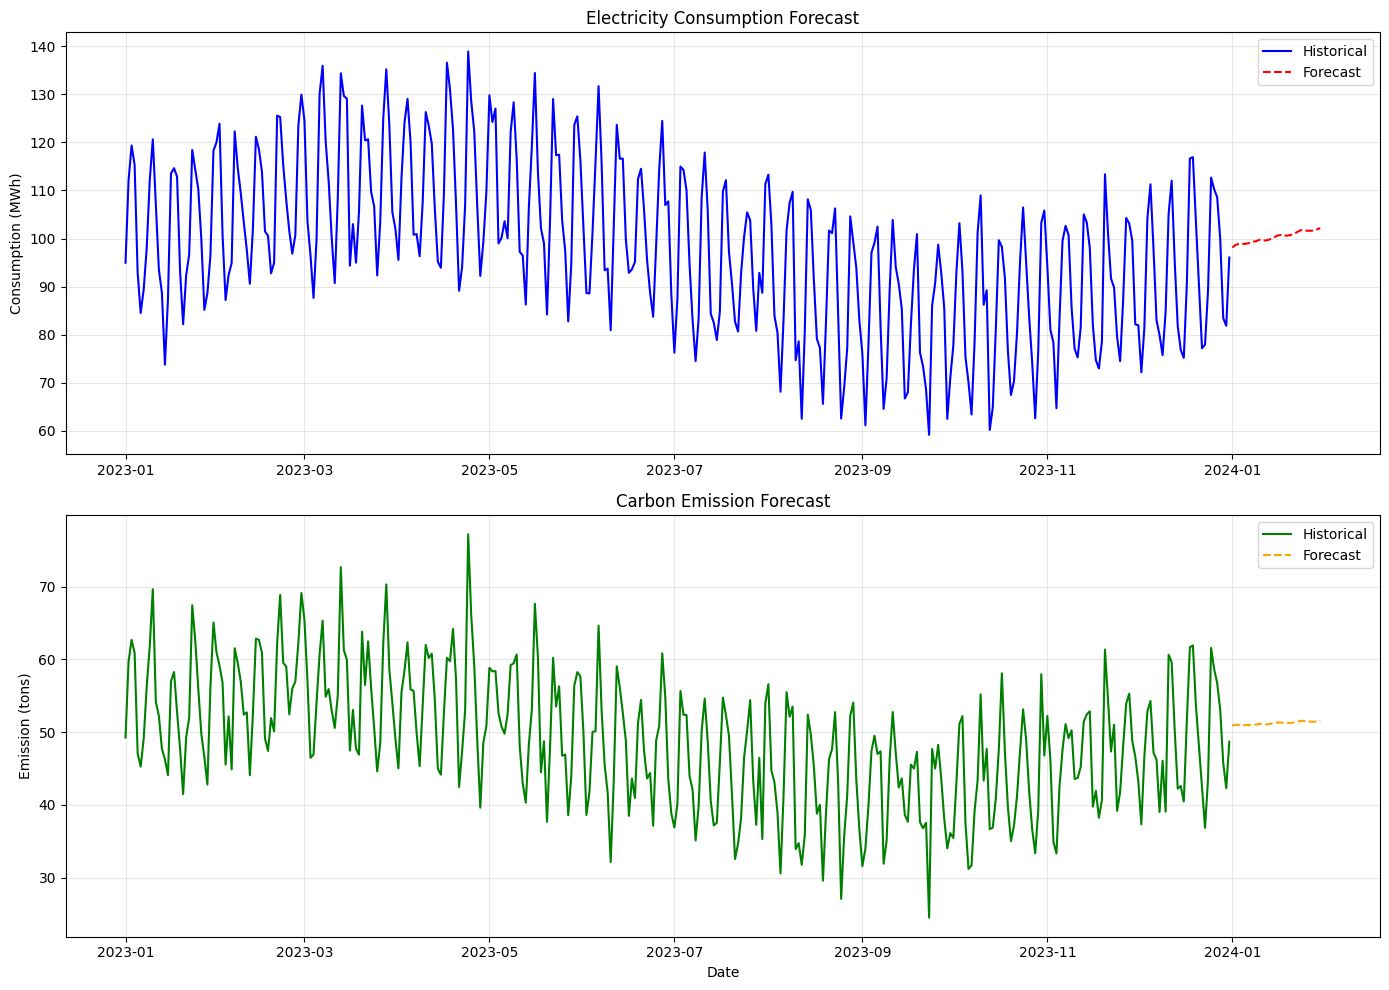

In [11]:
# Plot historical data with future forecast
plt.figure(figsize=(14, 10))

# Electricity consumption
plt.subplot(2, 1, 1)
plt.plot(energy_df.index, energy_df['electricity_consumption'], 
         label='Historical', color='blue')
plt.plot(future_forecast.index, future_forecast['electricity_consumption'], 
         label='Forecast', color='red', linestyle='--')
plt.title('Electricity Consumption Forecast')
plt.ylabel('Consumption (MWh)')
plt.legend()
plt.grid(True, alpha=0.3)

# Carbon emission
plt.subplot(2, 1, 2)
plt.plot(energy_df.index, energy_df['carbon_emission'], 
         label='Historical', color='green')
plt.plot(future_forecast.index, future_forecast['carbon_emission'], 
         label='Forecast', color='orange', linestyle='--')
plt.title('Carbon Emission Forecast')
plt.ylabel('Emission (tons)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# For better performance, try a Bidirectional LSTM
def create_bidirectional_lstm(seq_length, n_features):
    model = Sequential()
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(100, return_sequences=True), 
                           input_shape=(seq_length, n_features)))
    model.add(Dropout(0.3))
    
    # Second Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(100)))
    model.add(Dropout(0.3))
    
    # Dense layers
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(n_features))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create and train the advanced model (optional)
advanced_model = create_bidirectional_lstm(SEQ_LENGTH, n_features)
advanced_model.summary()

# Train the advanced model
advanced_history = advanced_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Compare performance
advanced_test_loss, advanced_test_mae = advanced_model.evaluate(X_test, y_test, verbose=0)
print(f"Original Model Test MAE: {test_mae:.4f}")
print(f"Advanced Model Test MAE: {advanced_test_mae:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 30, 200)             │          82,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,352 (1.27 MB)

 Trainable params: 333,352 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 269ms/step - loss: 0.0870 - mae: 0.2341 - val_loss: 0.0296 - val_mae: 0.1422 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0339 - mae: 0.1506 - val_loss: 0.0243 - val_mae: 0.1329 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0347 - mae: 0.1522 - val_loss: 0.0245 - val_mae: 0.1329 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0379 - mae: 0.1593 - val_loss: 0.0250 - val_mae: 0.1328 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0318 - mae: 0.1450 - val_loss: 0.0233 - val_mae: 0.1298 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0345 - mae: 0.1541 - val_loss: 0.0241 - val_mae: 0.1305 - learning_rate: 5.0000e-04
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0330 - mae: 0.1476 - val_loss: 0.0231 - val_mae: 0.1291 - learning_rate: 5.0000e-04
Epoch 8/10

In [13]:
# Save the model for future use
model.save('carbon_electricity_forecast_model.h5')
print("Model saved successfully!")

# To load the model later:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('carbon_electricity_forecast_model.h5')

Model saved successfully!
